In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import random
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
import string

/home/acours/miniconda3/envs/ing2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/acours/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
ds = load_dataset("jniimi/tripadvisor-review-rating")
raw_data = pd.DataFrame(ds["train"])

display(raw_data.head())

# Remove the System Prompt
df = raw_data.drop(columns=["stay_year", "post_date", "freq", "lang"])

# Drop the rows with missing User Prompt
df = df.dropna()

# Drop the duplicates
df = df.drop_duplicates()

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# FIXME: The dataset is not balanced

# FIXME: Remove this later, sampling only 10% of the dataset while developing
df = df.sample(frac=0.001).reset_index(drop=True)
print("Number of samples:", len(df))

,hotel_id,user_id,title,text,overall,cleanliness,value,location,rooms,sleep_quality,stay_year,post_date,freq,review,char,lang
0,127781101,2262DCBFC351F42A9DD30AC8BAD24686,Really excellent Hilton,Stayed here on business trips and the hotel is...,5.0,4.0,5.0,4.0,5.0,4.0,2012,2012-04-13,1,Really excellent Hilton\nStayed here on busine...,204,__label__en
1,137380592,8477E11DABF4D6743885E401BB4C8CCF,Exceptional service and comfort,Spent two nights here for a wedding in Brookly...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-08-16,1,Exceptional service and comfort\nSpent two nig...,621,__label__en
2,129673371,483A193B7113ADFFD5CE30849564F69C,Nice room and five star service,Great place for a 3-night stay. Our king room ...,5.0,5.0,5.0,3.0,5.0,4.0,2012,2012-05-09,1,Nice room and five star service\nGreat place f...,1259,__label__en
3,129006626,E5A63DD7239A7057746D4644A5C986EB,"BRILLIANT hotel, my #1 Chicago pick for busine...","This is my favorite hotel in Chicago, and I've...",5.0,5.0,5.0,5.0,5.0,5.0,2012,2012-04-28,1,"BRILLIANT hotel, my #1 Chicago pick for busine...",2242,__label__en
4,139168159,CBFE281C9386225267BC52518836A6C2,Convenient and comfortable,BEST. BREAKFAST. EVER. Couldn't have been happ...,5.0,5.0,4.0,5.0,4.0,5.0,2012,2012-09-02,1,Convenient and comfortable\nBEST. BREAKFAST. E...,511,__label__en


Number of samples: 201


In [4]:
reviews = list(df["text"])
tokens = [word_tokenize(sentence.lower()) for sentence in reviews]

In [5]:
# Load stopwords
stopwords_list = set(stopwords.words("english"))  # Use set for faster lookups


# Remove stopwords function
def remove_stopwords(tokens):
    return [
        [word for word in sentence if word.lower() not in stopwords_list]
        for sentence in tokens
    ]


# Punctuation removal function with sentence boundaries
def remove_punct(words):
    sentence = []
    processed = []

    for word in words:
        if word in ".!?":  # Sentence-ending punctuation
            if sentence:  # Avoid empty sentences
                processed.append(["[START]"] + sentence + ["[END]"])
                sentence = []  # Reset for next sentence
        elif word not in string.punctuation:  # Remove other punctuation
            sentence.append(word)

    if sentence:  # Edge case: last sentence without ending punctuation
        processed.append(["[START]"] + sentence + ["[END]"])

    return processed


reviews = remove_stopwords(tokens)
print(reviews[0:5])

reviews = [remove_punct(review) for review in reviews]
# Flatten the list of lists
reviews = [sentence for review in reviews for sentence in review]
# Remove empty sentences
reviews = [sentence for sentence in reviews if sentence]  # Remove empty sentences
print(reviews[0:5])

[['weekend', 'town', 'college', 'football', 'game', 'quick', 'sightseeing', 'jaunt', '.', 'first', 'ever', 'trip', 'philly', 'bride', 'got', 'good', 'package', 'price', 'loews', 'expedia', '.', 'besides', 'price', 'selected', 'central', 'downtown', 'close', 'historic', 'independence', 'square', 'area', 'fabulous', 'reading', 'terminal', 'market', ',', 'shopper', "'s", 'diner', "'s", 'delight', '.', 'cheap', 'easy', 'catch', 'train', 'airport', 'directly', 'market', 'east', 'station', 'across', 'street', 'hotel', '.', 'broad', 'street', 'subway', 'line', 'also', 'incredibly', 'simple', 'reach', 'lincoln', 'financial', 'field', 'sports', 'entertainment', 'district', 'game', 'day', 'events', '.', 'never', 'grab', 'cab', '.', 'could', 'easilty', 'walk', 'catch', 'transit', 'everything', 'wanted', '.', 'bonus', 'trip', 'hotel', 'built', 'historic', 'old', 'bank', 'building', 'updated', 'preserves', 'old', 'style', ',', 'vault', 'elevators', 'display', '.', 'cool', 'see', 'read', 'past', '.'

In [6]:
# Flatten review in a single list
flattened_reviews = [word for review in reviews for word in review]
print(flattened_reviews[0:5])

['[START]', 'weekend', 'town', 'college', 'football']


# Word 2 Vec Implemtation from scratch with pytorch

## Params

In [48]:
CONTEXT_SIZE = 4  # Window size
EMBEDDING_DIM = 256  # Dimension of word vectors
EPOCHS = 10
LEARNING_RATE = 0.01

### Build Vocabulary

In [49]:
word_counts = Counter(flattened_reviews)

vocab = {word: i for i, word in enumerate(word_counts.keys())}
rev_vocab = {i: word for word, i in vocab.items()}
vocab_size = len(vocab)
print(vocab_size)

3510


### Prepare Skip-gram Training Data

### Define Skip-gram Model

In [50]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_dim)
        # self.embeddings_context = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target):  # 2, context):
        embed_targ = self.embeddings_target(target)
        # embed_ctx = self.embeddings(context)
        # z = torch.mul(embed_targ, embed_ctx)
        # out = self.out_layer(z)
        out = self.out_layer(embed_targ)
        return out

### Train

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader


class Word2VecDataset(Dataset):
    def __init__(self, flattened_reviews, vocab, context_size):
        self.flattened_reviews = flattened_reviews
        self.vocab = vocab
        self.context_size = context_size
        self.data = []

        for i in range(context_size, len(flattened_reviews) - context_size):
            target = vocab[flattened_reviews[i]]
            context = [
                vocab[flattened_reviews[i - j]] for j in range(1, context_size + 1)
            ] + [vocab[flattened_reviews[i + j]] for j in range(1, context_size + 1)]
            self.data.append((target, context))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        target, context = self.data[index]
        target_tensor = torch.tensor(target, dtype=torch.long)
        context_tensor = torch.tensor(context, dtype=torch.long)
        return target_tensor, context_tensor


dataset = Word2VecDataset(flattened_reviews, vocab, CONTEXT_SIZE)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

for target, context in dataloader:
    print("Target:", target)
    print("Context:", context)
    break

Target: tensor([   0, 1056,  175,    9,   48,    9,  116, 1192,  128,  232,  193,  637,
           9, 2827,    9,  148,  621, 1979,   89, 2829, 1163,  528,  376,    9,
         560, 1068,    9,  154,   16,  364, 1483,    0,  916,  580,  909,  560,
         212, 3243,    9,  105,  364, 1029,   16,    0,  532, 1814, 3246,    9,
         340,  160, 2269, 1799,    0,  397, 2507,    0,    0,    0,  229,    0,
           0, 1605, 1935, 2947, 2615,  831,    0, 1442,  995,    9,  166,    9,
        3143, 1633,  249,  766,  993,    9,  257,  559, 2832,   48,    9, 2980,
        1890, 1853,   48,  728,    0, 2842,  626, 2194,  212,   29,    0,   48,
         853,    0,   48,  852,  365,    9, 2730,   48,    0,    9,  201,  135,
           9, 3276,  744, 3077,  766,  140, 1743,  712,    9,  166,  404, 3440,
        1693,   24,   67,  657, 2460,   48,    0, 1858])
Context: tensor([[   9,  627,   24,  ...,  211,  212,    9],
        [3060, 3059,  465,  ..., 2972,    9,    0],
        [2685,  492,  

In [52]:
# flattened_reviews

In [53]:
from tqdm import tqdm

model = Word2Vec(vocab_size, EMBEDDING_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    # progress_bar = tqdm(range(CONTEXT_SIZE, len(flattened_reviews) - CONTEXT_SIZE), desc=f"Epoch {epoch + 1}")
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    # for i in progress_bar:
    # target = vocab[flattened_reviews[i]]
    #     context = [vocab[flattened_reviews[i - j]] for j in range(1, CONTEXT_SIZE + 1)] + \
    #               [vocab[flattened_reviews[i + j]] for j in range(1, CONTEXT_SIZE + 1)]

    #     target_tensor = torch.tensor([target], dtype=torch.long, device=device)
    #     context_tensor = torch.tensor(context, dtype=torch.long, device=device)

    for target_tensor, context_tensor in progress_bar:
        target_tensor = target_tensor.to(device)
        context_tensor = context_tensor.to(device)

        optimizer.zero_grad()
        output = model(target_tensor)
        loss = 0
        # for context_word in context_tensor:
        # loss += criterion(output, context_word.unsqueeze(0))
        # loss += criterion(output, context_word.unsqueeze(0))

        for i in range(target_tensor.size(0)):
            for context_word in context_tensor[i]:
                loss += criterion(output[i].unsqueeze(0), context_word.unsqueeze(0))
        loss = loss / (target_tensor.size(0) * context_tensor.size(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1}, Total Loss: {total_loss:.4f}")

Epoch 1: 100%|██████████| 141/141 [00:42<00:00,  3.31it/s, loss=7.65]


Epoch 1, Total Loss: 1100.9050


Epoch 2: 100%|██████████| 141/141 [00:41<00:00,  3.41it/s, loss=7.01]


Epoch 2, Total Loss: 998.9771


Epoch 3: 100%|██████████| 141/141 [00:37<00:00,  3.76it/s, loss=6.62]


Epoch 3, Total Loss: 924.5712


Epoch 4: 100%|██████████| 141/141 [00:39<00:00,  3.53it/s, loss=6.24]


Epoch 4, Total Loss: 872.4670


Epoch 5: 100%|██████████| 141/141 [00:40<00:00,  3.45it/s, loss=5.86]


Epoch 5, Total Loss: 835.2334


Epoch 6: 100%|██████████| 141/141 [00:40<00:00,  3.44it/s, loss=5.66]


Epoch 6, Total Loss: 807.3150


Epoch 7: 100%|██████████| 141/141 [00:40<00:00,  3.49it/s, loss=5.81]


Epoch 7, Total Loss: 785.3957


Epoch 8: 100%|██████████| 141/141 [00:37<00:00,  3.75it/s, loss=5.52]


Epoch 8, Total Loss: 767.6352


Epoch 9: 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=5.39]


Epoch 9, Total Loss: 753.2567


Epoch 10: 100%|██████████| 141/141 [00:37<00:00,  3.75it/s, loss=5.4] 

Epoch 10, Total Loss: 741.2630


## Save the model

In [23]:
flattened_reviews[:50]
# context = [vocab[flattened_reviews[i - j]] for j in range(1, CONTEXT_SIZE + 1)] + \
#             [vocab[flattened_reviews[i + j]] for j in range(1, CONTEXT_SIZE + 1)]

# target_tensor = torch.tensor([target], dtype=torch.long, device=device)
# context_tensor = torch.tensor(context, dtype=torch.long, device=device)

['[START]',
 'experience',
 'came',
 'gaslamp',
 'business',
 'conference',
 'brought',
 'girlfriend',
 'along',
 'celebrate',
 'two',
 'year',
 'anniversary',
 '[END]',
 '[START]',
 'guest',
 'services',
 'manager',
 'hard',
 'rock',
 'worked',
 'beginning',
 'providing',
 'top-notch',
 'excellent',
 'service',
 'likes',
 'find',
 'outside',
 'vegas',
 '[END]',
 '[START]',
 'arrived',
 'treated',
 'royalty',
 'given',
 'complimentary',
 'drinks',
 'set',
 'fantastic',
 'modern',
 'trendy',
 'suite',
 'fantastic',
 'views',
 'gaslamp',
 'district',
 '[END]',
 '[START]',
 'concierge']

In [70]:
# Save the model
torch.save(model.state_dict(), "word2vec_model.pth")

# Save the vocabulary
with open("vocab.txt", "w") as f:
    for word, index in vocab.items():
        f.write(f"{word}\t{index}\n")

## Load the model

In [71]:
# # Load the vocabulary
vocab = {}
with open("vocab.txt", "r") as f:
    for line in f:
        word, index = line.strip().split("\t")
        vocab[word] = int(index)

# Load the model
model.load_state_dict(torch.load("word2vec_model.pth"))
model.eval()

Word2Vec(
  (embeddings_target): Embedding(3510, 256)
  (out_layer): Linear(in_features=256, out_features=3510, bias=True)
)

## Test the embeddings

In [72]:
from scipy.spatial.distance import cosine


# Function to get the word vector
def get_word_vector(word):
    if word in vocab:
        index = vocab[word]
        return (
            model.embeddings_target(torch.tensor(index, device=device))
            .detach()
            .cpu()
            .numpy()
        )
    else:
        print(f"Word '{word}' not found in vocabulary.")
        return None


# Function to perform word arithmetic
def word_arithmetic(word1, operator, word2):
    vec1 = get_word_vector(word1)
    vec2 = get_word_vector(word2)

    if vec1 is not None and vec2 is not None:
        if operator == "+":
            result = vec1 + vec2
        elif operator == "-":
            result = vec1 - vec2
        else:
            print(f"Unsupported operator '{operator}'. Use '+' or '-'.")
            return None
        return result
    else:
        return None


# Function to test operations
def test_operations(test):
    results = []
    for i in range(0, len(test) - 2, 3):
        word1, operator, word2 = test[i], test[i + 1], test[i + 2]
        result_vector = word_arithmetic(word1, operator, word2)
        if result_vector is not None:
            results.append((result_vector, {word1, word2}))
        else:
            print(f"Could not perform operation on '{word1} {operator} {word2}'.")
    return results


# Function to find the closest word
def find_closest_word(vector, excluded_words):
    closest_word = None
    closest_distance = float("inf")

    for word, index in vocab.items():
        if word not in excluded_words:
            word_vector = (
                model.embeddings_target(torch.tensor(index, device=device))
                .detach()
                .cpu()
                .numpy()
            )
            distance = cosine(vector, word_vector)
            if distance < closest_distance:
                closest_distance = distance
                closest_word = word

    return closest_word, closest_distance


# Test the operations
test = ["cheap", "+", "bad"]
results = test_operations(test)
# results = [get_word_vector("cheap")]
# Find the closest word for each result
for result_vector, excluded_words in results:
    closest_word, closest_distance = find_closest_word(result_vector, excluded_words)
    print(
        f"The closest word to the result vector is '{closest_word}' with a cosine distance of {closest_distance:.4f}"
    )

The closest word to the result vector is 'ride' with a cosine distance of 0.7835


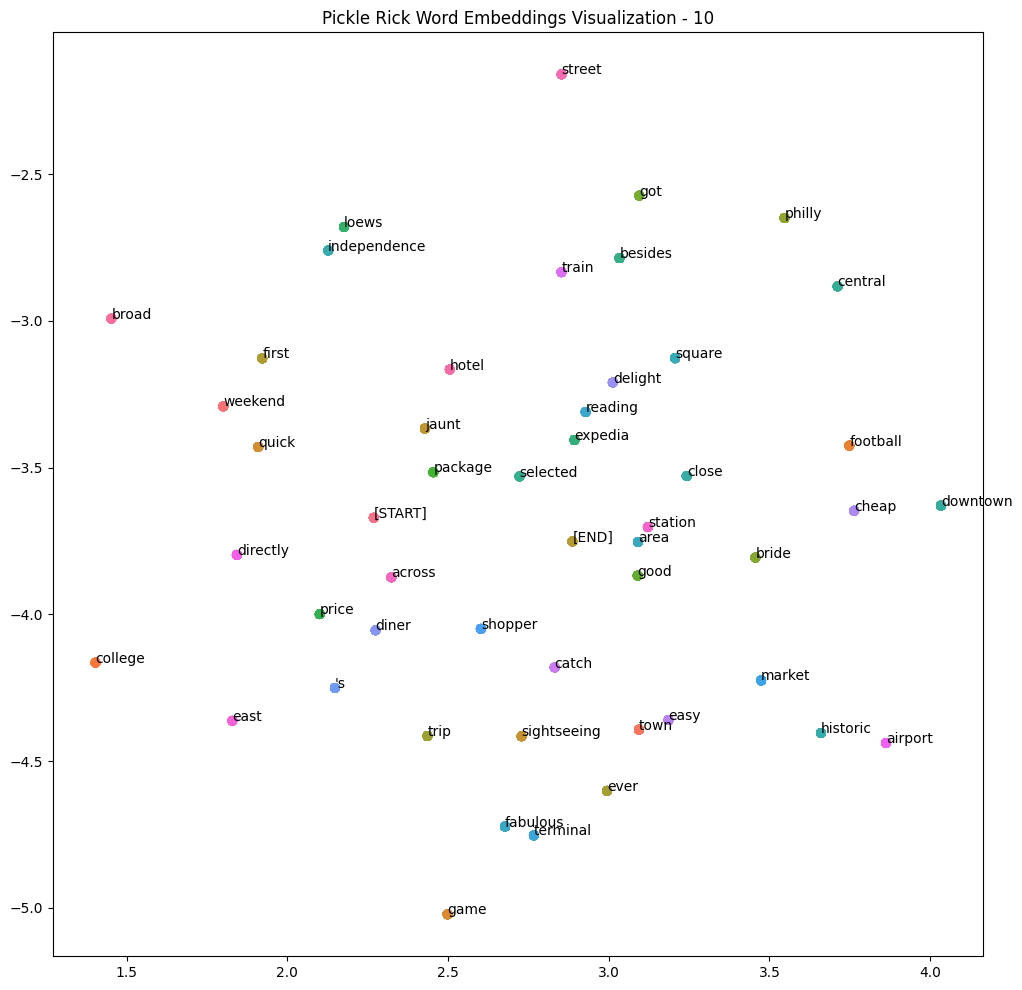

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns


def visualize_words_embedding(model, epoch_number):
    words_to_visualize = [k for k in vocab.keys()]
    words_to_visualize = words_to_visualize[:50]

    word_vectors = model.embeddings_target.weight.data

    indices = [vocab[word] for word in words_to_visualize]
    word_vectors = model.embeddings_target.weight.data[indices]

    tsne = TSNE(n_components=2, perplexity=30)
    word_vectors_2d = tsne.fit_transform(word_vectors.cpu())

    colors = sns.husl_palette(n_colors=len(words_to_visualize))

    plt.figure(figsize=(12, 12))

    for i, word in enumerate(words_to_visualize):
        plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c=colors)
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

    plt.title(f"Pickle Rick Word Embeddings Visualization - {epoch_number}")

    plt.savefig(f"word_embeddings_epoch_{epoch_number}.png")


visualize_words_embedding(model, epoch_number=10)

{'[START]': 0, 'weekend': 1, 'town': 2, 'college': 3, 'football': 4, 'game': 5, 'quick': 6, 'sightseeing': 7, 'jaunt': 8, '[END]': 9, 'first': 10, 'ever': 11, 'trip': 12, 'philly': 13, 'bride': 14, 'got': 15, 'good': 16, 'package': 17, 'price': 18, 'loews': 19, 'expedia': 20, 'besides': 21, 'selected': 22, 'central': 23, 'downtown': 24, 'close': 25, 'historic': 26, 'independence': 27, 'square': 28, 'area': 29, 'fabulous': 30, 'reading': 31, 'terminal': 32, 'market': 33, 'shopper': 34, "'s": 35, 'diner': 36, 'delight': 37, 'cheap': 38, 'easy': 39, 'catch': 40, 'train': 41, 'airport': 42, 'directly': 43, 'east': 44, 'station': 45, 'across': 46, 'street': 47, 'hotel': 48, 'broad': 49, 'subway': 50, 'line': 51, 'also': 52, 'incredibly': 53, 'simple': 54, 'reach': 55, 'lincoln': 56, 'financial': 57, 'field': 58, 'sports': 59, 'entertainment': 60, 'district': 61, 'day': 62, 'events': 63, 'never': 64, 'grab': 65, 'cab': 66, 'could': 67, 'easilty': 68, 'walk': 69, 'transit': 70, 'everything': 